## Pre-Requisites to run this notebook

In [2]:
!pip install plotly.express 
!pip install plotly

# 1. Data Description

The dataset consists of the prices of popular Apple products across 26 countries (Dated 2nd January 2022).

* model: Stores the model names of the Apple devices
* price: Stores the prices of the products in different currencies
* country_code: Stores country codes representing different markets
* country: Stores country names corresponding to the country codes
* region: Stores regional classifications for the countries
* scraped_date: Stores the date and time when the data was collected
* income_group: Stores the income group classification for each country


In [5]:
from itertools import product
from typing import Callable

import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import requests
from plotly.subplots import make_subplots

apple_price_data = pd.read_csv("apple product price list from 26 countries.csv",    index_col="pid",    parse_dates=["scraped_date"],)

# Make the index unique
apple_price_data.index = (
    apple_price_data["country_code"] + "-" + apple_price_data.index.map(str)
)

# Use CategoricalDtype for categorical cols, for memory efficiency and to
# allow sorting in the case of income category.
apple_price_data[["country_code", "country", "region"]] = apple_price_data[
    ["country_code", "country", "region"]
].astype("category")
apple_price_data["income_group"] = pd.Categorical(
    apple_price_data["income group"],
    categories=["Lower middle income", "Upper middle income", "High income"],
    ordered=True,
)
apple_price_data.drop(columns=["income group"], inplace=True) # replaced with income_group
apple_price_data.info()
apple_price_data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 448 entries, au-0 to us-16
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   model         448 non-null    object        
 1   price         448 non-null    object        
 2   country_code  448 non-null    category      
 3   country       448 non-null    category      
 4   region        448 non-null    category      
 5   scraped_date  448 non-null    datetime64[ns]
 6   income_group  448 non-null    category      
dtypes: category(4), datetime64[ns](1), object(2)
memory usage: 18.6+ KB


,model,price,country_code,country,region,scraped_date,income_group
au-0,iPhone 13,"From A$1,199",au,Australia,East Asia & Pacific,2022-01-02 21:52:06.630535,High income
au-1,iPhone SE,From A$679,au,Australia,East Asia & Pacific,2022-01-02 21:52:06.630535,High income
au-2,iPhone 12,From A$999,au,Australia,East Asia & Pacific,2022-01-02 21:52:06.630535,High income
au-3,AirPods(3rd generation),A$279,au,Australia,East Asia & Pacific,2022-01-02 21:52:06.630535,High income
au-4,AirPods Pro,A$399,au,Australia,East Asia & Pacific,2022-01-02 21:52:06.630535,High income


# 2. Data Cleaning

The following steps ensure an effective price comparison:

* Non-numeric characters were stripped away like currency symbols and product descriptions
* Separators were standardized by replacing region-specific thousands separators (e.g., commas) with a common one (e.g., period)
* Prices were ensured to have the standard decimal mark for easier numerical operations
* Appropriate exchange rates were used to convert all prices to a single reference currency (e.g., USD)

In [6]:
# Undelimited prices e.g. 'From $949'
undelimited = dict(
    countries=["Canada", "India", "Poland", "Portugal", "United States"],
    cleaning_func=lambda prices: prices.str.extract("(\d+)"),
)
# Space-delimited prices e.g. 'À partir de 1 449 €'
space_delimited = dict(
    countries=["Czech Republic", "Finland", "France", "Hungary", "Norway",
               "Russia", "Sweden"],
    cleaning_func=lambda prices: prices.str.replace(" ", "").str.extract("(\d+)"),
)
# Space-delimited prices with comma as decimal seperator e.g. 'À partir de 1 401,10 €'
space_delimited_with_comma_decimal = dict(
    countries=["Luxembourg"],
    cleaning_func=lambda prices: prices.str.replace(" ", "")
                                       .str.replace(",", ".")
                                       .str.extract("(\d+\.?\d*)"),
)
# Comma-delimited prices e.g. 'From A$1,899'
comma_delimited_no_decimal = dict(
    countries=["Australia", "Ireland", "Mexico", "Philippines", "Thailand"],
    cleaning_func=lambda prices: prices.str.replace(",", "").str.extract("(\d+)"),
)
# Period-delimited prices e.g. 'Ab 1.449 €'
period_delimited_no_decimal = dict(
    countries=["Austria", "Brazil", "Denmark", "Italy", "Spain", "Turkey"],
    cleaning_func=lambda prices: (
        prices.str.replace(".", "", regex=False).str.extract("(\d+)")
    ),
)
# Period-delimited prices with decimals e.g. '1.612,70 €'
period_delimited_with_comma_decimal = dict(
    countries=["Germany", "Netherlands"],
    cleaning_func=lambda prices: (
        prices.str.replace(".", "", regex=False)
        .str.replace(",", ".")
        .str.extract("(\d+\.?\d*)")
    ),
)


def clean_prices(countries: list, cleaning_func: Callable) -> pd.DataFrame:
    """Extract numeric value of prices for the given `countries` using the
    `cleaning_func`.

    Args:
        countries (list): Countries with similar thousands & decimal delimiters.
        cleaning_func (Callable): Function that extracts digits from text.

    Returns
        pandas.DataFrame: A column of numeric values.
    """
    prices = apple_price_data.query("country in @countries")["price"]
    return cleaning_func(prices).astype(float)


cleaned_prices = pd.concat(
    clean_prices(**category)
    for category in [
        undelimited,
        space_delimited,
        space_delimited_with_comma_decimal,
        comma_delimited_no_decimal,
        period_delimited_no_decimal,
        period_delimited_with_comma_decimal,
    ]
).rename(columns={0: "cleaned_price"})

apple_price_data = pd.concat([apple_price_data, cleaned_prices], axis=1)
apple_price_data.filter(like="price", axis=1).head()

,price,cleaned_price
au-0,"From A$1,199",1199.0
au-1,From A$679,679.0
au-2,From A$999,999.0
au-3,A$279,279.0
au-4,A$399,399.0


In [7]:
# Convert to common currency (USD)

# Sample exchange rate CSV
exchange_rate_data = {
    "Currency CodeA": ["AUD", "EUR", "BRL", "CAD", "CZK", "DKK", "HUF", "INR", "MXN", "NOK", "PHP", "PLN", "RUB", "SEK", "THB", "USD"],
    "X": [1.3861900568008423, 0.8845999836921692, 5.660699844360352, 1.274399995803833, 21.944000244140625, 6.583499908447266, 323.5899963378906, 74.50800323486328, 20.547000885009766, 8.86832046508789, 51.290000915527344, 4.051000118255615, 74.90879821777344, 9.08942985534668, 33.29800033569336, 1.0],
}
exchange_rates_to_usd = pd.DataFrame(exchange_rate_data)

# Get unique currency codes in the DataFrame
unique_currency_codes = exchange_rates_to_usd["Currency CodeA"].unique()

# Create a dictionary mapping currency codes to corresponding 'X' column values
currency_to_x_mapping = {}

# Populate the dictionary
for currency_code in unique_currency_codes:
    x_value = exchange_rates_to_usd.loc[exchange_rates_to_usd["Currency CodeA"] == currency_code, "X"].values[0]
    currency_to_x_mapping[currency_code] = x_value

# Display the resulting dictionary
print("Currency to X Mapping:")
print(currency_to_x_mapping)

# Dictionary of countries
country_mapping = {
    "Australia": "AUD",
    "Austria": "EUR",
    "Brazil": "BRL",
    "Canada": "CAD",
    "Czech Republic": "CZK",
    "Denmark": "DKK",
    "Finland": "EUR",
    "France": "EUR",
    "Germany": "EUR",
    "Hungary": "HUF",
    "India": "INR",
    "Ireland": "EUR",
    "Italy": "EUR",
    "Luxembourg": "EUR",
    "Mexico": "MXN",
    "Netherlands": "EUR",
    "Norway": "NOK",
    "Philippines": "PHP",
    "Poland": "PLN",
    "Portugal": "EUR",
    "Russia": "RUB",
    "Spain": "EUR",
    "Sweden": "SEK",
    "Thailand": "THB",
    "Turkey": "THB",
    "United States": "USD",
}

# Create a new dictionary mapping countries to corresponding 'X' column values
country_to_x_mapping={}

for country,currency_code in country_mapping.items():
    country_to_x_mapping[country]=currency_to_x_mapping[currency_code]


# Display the resulting dictionary
print("\nCountry to X Mapping:")
print(country_to_x_mapping)

apple_price_data["price"] = apple_price_data.apply(
    lambda x: x["cleaned_price"] / country_to_x_mapping[x["country"]], axis=1
)

# Drop the "cleaned_price" column
apple_price_data.drop(columns=["cleaned_price"], inplace=True)

# Display the updated DataFrame
apple_price_data.head()

Currency to X Mapping:
{'AUD': 1.3861900568008423, 'EUR': 0.8845999836921692, 'BRL': 5.660699844360352, 'CAD': 1.274399995803833, 'CZK': 21.944000244140625, 'DKK': 6.583499908447266, 'HUF': 323.5899963378906, 'INR': 74.50800323486328, 'MXN': 20.547000885009766, 'NOK': 8.86832046508789, 'PHP': 51.290000915527344, 'PLN': 4.051000118255615, 'RUB': 74.90879821777344, 'SEK': 9.08942985534668, 'THB': 33.29800033569336, 'USD': 1.0}

Country to X Mapping:
{'Australia': 1.3861900568008423, 'Austria': 0.8845999836921692, 'Brazil': 5.660699844360352, 'Canada': 1.274399995803833, 'Czech Republic': 21.944000244140625, 'Denmark': 6.583499908447266, 'Finland': 0.8845999836921692, 'France': 0.8845999836921692, 'Germany': 0.8845999836921692, 'Hungary': 323.5899963378906, 'India': 74.50800323486328, 'Ireland': 0.8845999836921692, 'Italy': 0.8845999836921692, 'Luxembourg': 0.8845999836921692, 'Mexico': 20.547000885009766, 'Netherlands': 0.8845999836921692, 'Norway': 8.86832046508789, 'Philippines': 51.29

,model,price,country_code,country,region,scraped_date,income_group
au-0,iPhone 13,864.960756,au,Australia,East Asia & Pacific,2022-01-02 21:52:06.630535,High income
au-1,iPhone SE,489.831821,au,Australia,East Asia & Pacific,2022-01-02 21:52:06.630535,High income
au-2,iPhone 12,720.680397,au,Australia,East Asia & Pacific,2022-01-02 21:52:06.630535,High income
au-3,AirPods(3rd generation),201.271102,au,Australia,East Asia & Pacific,2022-01-02 21:52:06.630535,High income
au-4,AirPods Pro,287.839318,au,Australia,East Asia & Pacific,2022-01-02 21:52:06.630535,High income


In [8]:
#Harmonize Product Names

model_info = apple_price_data["model"].copy()


def clean_product_names(search_phrase: str, correct_name: str) -> None:
    """Rename all products containing `search_phrase` as `correct_name`.
    
    Args:
        search_phrase (str): Regex pattern for names to replace.
        correct_name (str): English name for the product.
    """
    matches = model_info.str.contains(search_phrase, case=False)
    model_info[matches] = correct_name


clean_product_names("iMac", "24-inch iMac")
clean_product_names(
    "AirPods\(2|AirPods\(se|AirPods\(andra|AirPods\(รุ่นที่ 2",
    "AirPods(2nd generation)",
)
clean_product_names(
    "AirPods\(3|AirPods\(t|AirPods\(รุ่นที่ 3", "AirPods(3rd generation)"
)
clean_product_names("Apple Pencil", "Apple Pencil")
clean_product_names(
    "Spor|Correa deportiva|Спортивный ремешок|Urheiluranneke", "Sports Band"
)
clean_product_names("regalo|Tarjetas|Подарочные карты|Hediye Kartı", "Gift Cards")
clean_product_names("Mouse", "Magic Mouse")

apple_price_data["model"] = model_info
print("\tProducts in dataset:\n", "\t" + "-" * 19 + "\n", model_info.unique())

	Products in dataset:
 	-------------------
 ['iPhone 13' 'iPhone SE' 'iPhone 12' 'AirPods(3rd generation)'
 'AirPods Pro' 'AirPods(2nd generation)' 'AirPods Max' 'Apple TV 4K'
 'Apple Watch SE' 'Apple Watch Series 3' 'Sports Band' 'iPad' 'iPad Pro'
 'Apple Pencil' '24-inch iMac' 'MacBook Air' 'Magic Mouse' 'Apple TV HD'
 'iPhone 13 Pro' 'Gift Cards']


# 3. Data Analysis

# 3.1. Global Market Coverage

## Price Variations in Apple Products

* Significant Price Variations: Prices for the same Apple products vary considerably across countries, even after accounting for currency exchange rates. This suggests the influence of other factors beyond currency fluctuations.
* Regional Factors: Taxes, import duties, and distribution costs likely contribute to price differences. Countries with higher taxes or import duties generally have higher Apple product prices.
* Income Group Correlation: Prices tend to be higher in high-income countries compared to lower-income countries. This aligns with Apple's premium brand positioning and strategy of targeting affluent consumers.
* Pricing Strategy Adaptability: Apple adjusts prices based on regional factors and target markets, aiming to maximize profitability and maintain a premium brand image.


## Global Income Divide

* Global Income Divide: The geo-scatter plot highlights disparities in income levels across countries, which likely correlate with Apple's pricing strategies.
* Digital Divide: The graph from the Philippines underscores the income-based gap in mobile device usage, further emphasizing the connection between income levels and access to technology.


In [9]:
#Summary Statistics
apple_price_data.describe()

,price,scraped_date
count,443.000000,448
mean,511.814051,2022-01-02 21:52:25.979973376
min,14.985885,2022-01-02 21:52:06.630535
25%,175.378191,2022-01-02 21:52:15.114080
50%,315.396795,2022-01-02 21:52:24.622852096
75%,777.581696,2022-01-02 21:52:38.882844928
max,3108.979540,2022-01-02 21:52:47.021744
std,463.976915,NaN


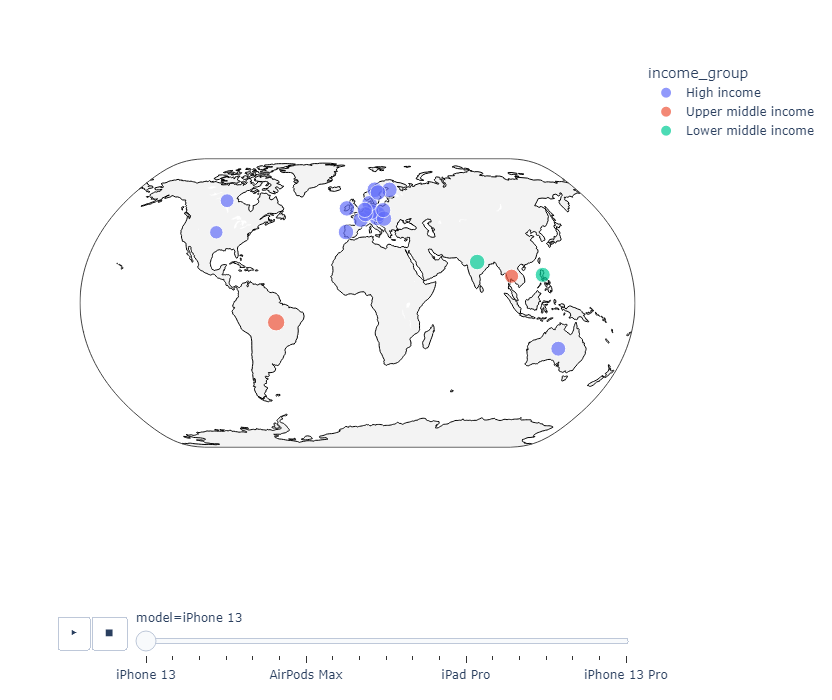

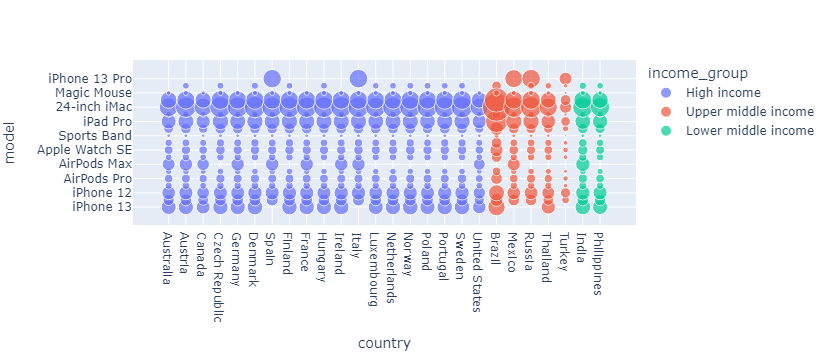

In [12]:
# GEOSCATTER PLOT
import plotly.express as px

# Assuming 'price' is the column containing the size values
apple_price_data = apple_price_data.dropna(subset=['price'])

fig = px.scatter_geo(
    apple_price_data,
    locations="country",
    locationmode="country names",
    color="income_group",
    size="price",
    hover_name="model",
    animation_frame="model",
    animation_group="country",
    projection="natural earth",
    width=1200,
    height=700
    
)

# Update layout for better mapping
fig.update_geos(
    showcoastlines=True,
    coastlinecolor="black",
    showland=True,
    landcolor="rgb(243, 243, 243)",
)

fig_scatter = px.scatter(
    apple_price_data,
    x="country",
    y="model",
    color="income_group",
    size="price",
    hover_name="model",
)
# Show the plot
fig.show()
fig_scatter.show()

# 3.2. Product Prices

## Regional Average Prices

* North America: The most affordable region with an average price of USD 425.48
* East Asia & Pacific: Second most affordable region with an average price of USD 449.88
* Europe & Central Asia: third most affordable region with an average price of USD 509.19
* South Asia: Second most expensive region with an average price of USD 528.95
* Latin America & Caribbean: The most expensive region with an average price of USD 711.51

There's a significant price disparity between regions, with Latin America & Caribbean being almost twice as expensive as East Asia & Pacific on average.This disparity could be due to factors like taxes, import duties, currency exchange rates, and potentially different pricing strategies by Apple.

## Most and Least Expensive Products

* 24-inch iMacs: The most expensive product across all regions. 
The most expensive one is in Brazil (USD 3108.98), while the cheapest is in the US (USD 1299.00)
* Sports Bands: The least expensive product across all regions. 
The cheapest one is in Turkey (USD 14.98), while the most expensive is in Brazil (USD 58.35)

Price variations are present even within the same product category.Regional income levels might play a role in pricing, with some higher-income countries having slightly higher prices for certain products.


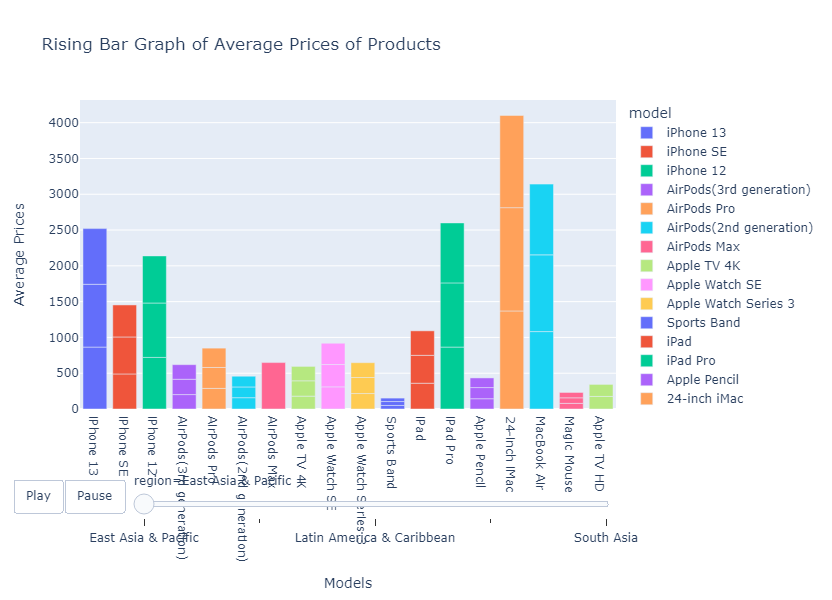

In [13]:
#Product Prices

import plotly.express as px

average_prices = (
    apple_price_data.groupby("model")["price"]
    .mean()
    .dropna()
    .sort_values(ascending=False)
)

fig = px.bar(apple_price_data, x='model', y='price', color='model',
             animation_frame='region', title='Rising Bar Graph of Average Prices of Products',
             labels={'x': ' ' ,'y': 'Average Prices'},
             height=600)

# Updating layout with play/pause buttons
fig.update_layout(updatemenus=[dict(type='buttons', showactive=False,
                                    buttons=[dict(label='Play',
                                                  method='animate',
                                                  args=[None, dict(frame=dict(duration=1500, redraw=True),
                                                                  fromcurrent=True)]),
                                            dict(label='Pause',
                                                  method='animate',
                                                  args=[[None], dict(frame=dict(duration=500, redraw=True),
                                                                    mode='immediate',
                                                                    transition=dict(duration=500))])])],
                 xaxis_title="Models", yaxis_title="Average Prices",
                 xaxis=dict(type='category'))

# Display the plot
fig.show()


In [14]:
# Calculate average prices for different regions
average_prices = (
    apple_price_data.groupby("region")["price"]
    .mean()
    .dropna()
    .sort_values(ascending=False)
)
average_prices.head()

region
Latin America & Caribbean    711.514319
South Asia                   528.951380
Europe & Central Asia        509.192593
East Asia & Pacific          449.881470
North America                425.483716
Name: price, dtype: float64

In [15]:
# Calculate average prices for different regions
average_prices = (
    apple_price_data.groupby("region")["price"]
    .mean()
    .dropna()
    .sort_values(ascending=False)
)

# Find the most expensive product and its price
most_expensive_product = apple_price_data.loc[apple_price_data.groupby("region")["price"].idxmax()]

# Find the least expensive product and its price
least_expensive_product = apple_price_data.loc[apple_price_data.groupby("region")["price"].idxmin()]

# Calculate price range for different regions
price_range = apple_price_data.groupby("region")["price"].agg(lambda x: x.max() - x.min())

# Display the results
print("Most Expensive Product:")
print(most_expensive_product)

print("\nLeast Expensive Product:")
print(least_expensive_product)

print("\nPrice Range for Different Regions:")
print(price_range)

Most Expensive Product:
              model        price country_code        country  \
ph-14  24-inch iMac  1442.581374           ph    Philippines   
se-14  24-inch iMac  1759.736337           se         Sweden   
br-13  24-inch iMac  3108.979540           br         Brazil   
us-14  24-inch iMac  1299.000000           us  United States   
in-15  24-inch iMac  1609.223101           in          India   

                          region               scraped_date  \
ph-14        East Asia & Pacific 2022-01-02 21:52:35.094330   
se-14      Europe & Central Asia 2022-01-02 21:52:42.128726   
br-13  Latin America & Caribbean 2022-01-02 21:52:09.264138   
us-14              North America 2022-01-02 21:52:47.021744   
in-15                 South Asia 2022-01-02 21:52:21.513688   

              income_group  
ph-14  Lower middle income  
se-14          High income  
br-13  Upper middle income  
us-14          High income  
in-15  Lower middle income  

Least Expensive Product:
            

# 3.3. Price Distribution by Income Group

## Income Groups

* Majority of countries fall in the High Income Group:
The largest portion i.e. 73.1% represents countries classified as upper-middle income suggesting that a significant proportion of the 26 countries have advanced economies with high levels of income per capita. There is a focus on wealthier markets as per the data.

* Minority of the countries fall in the Lower-Middle Income Group:
A smaller segment i.e. 7.69% represents lower-middle income countries indicating that a lesser number of countries in the dataset have economies that are still developing. This potentially indicates a gap in data for less affluent markets.

* Upper-Middle Income Countries Are Present:
The remaining 19.2% represents upper-middle income countries suggesting that some of the countries in the dataset have relatively developed economies. 


## Price Variation by Income Groups 

* Largest Price Differences: 
The biggest price differences are seen for high-end products like the 24-inch iMac, iPhone 13 Pro, and MacBook Air. These products have a price gap of around USD 200-300 between the lower and upper-middle income groups.

* Smaller Price Differences: 
For more affordable products like the Apple Watch SE, AirPods Pro, and Apple TV 4K, the price differences between income groups are smaller, ranging from USD 20-40.

* Outliers: 
Some products, like the iPhone 13 Pro and AirPods Max appear to have missing data for the lower-middle income group. This makes it difficult to draw definitive conclusions about price differences for these products across all income levels.
The box plot highlights the distribution of prices within each income group for specific products. This reveals that the higher prices in high-income groups are driven by a few outliers or a general upward shift.

* Regional Price Disparities:
The most expensive 24-inch iMac is in an upper-middle-income country (Brazil), followed by a high-income country (Sweden).
The least expensive Sports Band is in an upper-middle-income country (Turkey).
Latin America & Caribbean has the highest price range, with the most expensive 24-inch iMac costing USD 3108.98 in Brazil.
North America has the lowest price range, with the 24-inch iMac priced at USD 1299 in the US.

This suggests that Apple doesn't consistently price products higher in high-income countries compared to lower-income ones. Regional factors, taxes, import duties, and local market dynamics likely also influence pricing.

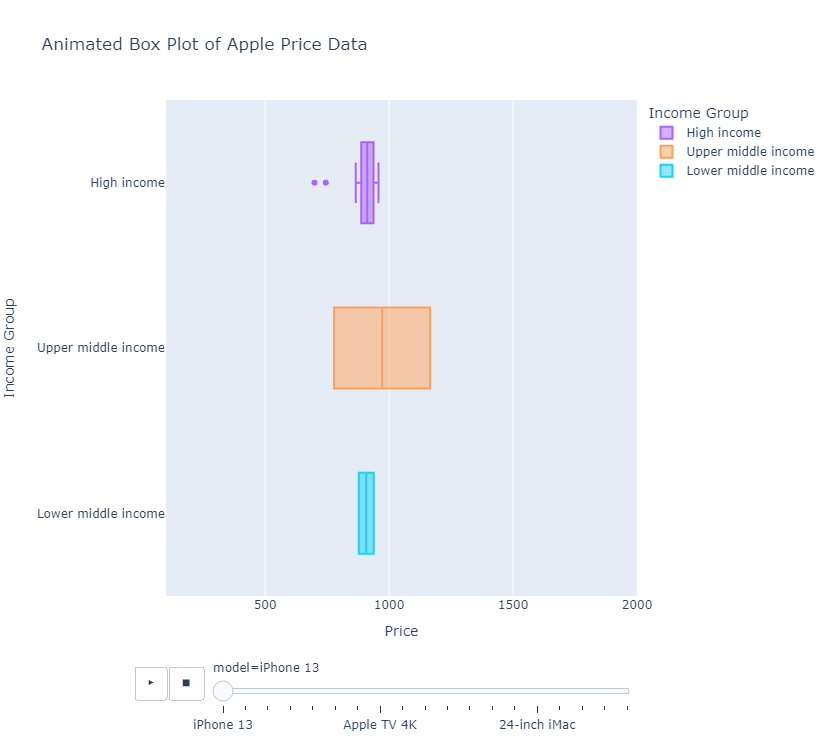

In [16]:
#BOX PLOT

fig_box = px.box(
    apple_price_data,
    x="price",
    y="income_group",
    color="income_group",
    animation_frame="model",
    title="Animated Box Plot of Apple Price Data",
    labels={"income_group": "Income Group", "price": "Price"},
    category_orders={"income_group": ["Low", "Medium", "High"]},  # Specify the order of categories
    width=1200,  # Set plot width
    height=750,  # Set plot height
)
fig_box.update_xaxes(range=[100,2000])
# Show the plot
fig_box.show()

# 3.4. Limitations

* Sample Size: The data represents a small subset of Apple products and countries. A more comprehensive analysis would require a larger dataset.

* Income Group Classification: The specific criteria used to classify countries into income groups is unknown.This limits the understanding of the nuances and potential variations within each income group, across different countires.

* Additional Factors: The data considers income group as a single factor of economic development. Other factors like human development, political stability, and environmental resources also play a role in a country's overall well-being.

* Missing Data: The missing data for the iPhone 13 Pro and AirPods Max in the lower-middle income group limits the analysis.

# 4. Managerial Insights and Recommendations

## Pricing Strategy

* Regional Differentiation: Adapt pricing strategies to specific regions by considering taxes, import duties, distribution costs, and currency fluctuations. This can involve setting regional target prices and adjusting product costs accordingly.

* Income Group Targeting: Differentiate prices for high-end products based on income group, potentially charging slightly more in wealthier markets for premium positioning. However, avoid excessive price variations to maintain brand accessibility.

* Transparency and Justification: Clearly communicate pricing rationale to consumers, addressing potential concerns about regional disparities and ensuring perceived value for the price in each market.

## Market Expansion

* Targeting Underrepresented Income Groups: Explore alternative payment options, financing arrangements, or trade-in programs to make Apple products more accessible to a wider range of consumers across different income levels.

* Bridging the Digital Divide: Develop initiatives to address the income-based gap in technology access, potentially through educational programs, partnerships with local organizations, or subsidized device programs.

## Product Portfolio

* Diversification for Affordability: Expand the product portfolio with slightly more affordable options alongside premium offerings. This caters to a wider range of income levels and potentially increases market share.

* Regional Market Customization: Consider tailoring product features and specifications to regional preferences and needs, potentially offering entry-level or simplified versions in lower-income markets.



        Overall, Apple needs to balance its premium brand positioning with accessibility and market expansion considerations. 
        By adopting a regionally-adapted pricing strategy, diversifying its product portfolio, and addressing the digital divide, 
        Apple can reach a wider customer base and maximize its global market potential.
